# Part 1: Import packages

In [1]:
# Launch from terminal with the
# PYTHONHASHSEED=0 jupyter notebook

import os
os.environ["MKL_DYNAMIC"] = "FALSE"
os.environ["MKL_CBWR"] = "COMPATIBLE"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
from numpy.random import SeedSequence
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import norm
from scipy.stats import beta
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
import warnings # warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
import time

In [32]:
# PLEASE MAKE SURE THE PACKAGE VERSIONS MATCH THOSE IN THE README
import sys
import scipy
import sklearn
import joblib

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("scipy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("joblib:", joblib.__version__)

Python: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:45:13) [Clang 16.0.6 ]
pandas: 2.1.4
numpy: 1.26.2
matplotlib: 3.8.2
scipy: 1.11.4
scikit-learn: 1.3.2
joblib: 1.3.2


# Part 2: Define functions and estimators

In [3]:
# function to generate multivariate normal samples

# NOTE!! 
#    - The numpy default function multivariate_normal is not stable!
#    - The function multivariate_normal needs a matrix factorization of Σ, which is handed off to LAPACK/BLAS, 
#         and that’s where the OS-dependent rounding differences crept in.
#    - For simple univariate or independent draws, there’s no BLAS call — just a transformation 
#         of uniform random numbers from the PCG64 stream.

def sample_equicorr_X(rng, n, p, mean_X=0.2, rho=0.1):
    z0 = rng.normal(size=n)          # common factor per row
    z  = rng.normal(size=(n, p))     # idiosyncratic shocks
    return mean_X + np.sqrt(rho) * z0[:, None] + np.sqrt(1.0 - rho) * z

In [4]:
# Panel DGP

def gen_panel(p, n, seed):    
    # ---- RNG setup: one master seed, independent substreams ----
    ss = np.random.SeedSequence(seed)
    ss_XD, ss_Dprime, ss_e1, ss_e2, ss_e3 = ss.spawn(5)
    rng_XD     = np.random.default_rng(ss_XD)      # for X and D
    rng_Dprime = np.random.default_rng(ss_Dprime)  # for D'
    rng_e1     = np.random.default_rng(ss_e1)
    rng_e2     = np.random.default_rng(ss_e2)
    rng_e3     = np.random.default_rng(ss_e3)

    # ---- Parameters ----
    mean_X = 0.2
    rho = 0.1

    gamma = np.array([0.5 / (j**2) for j in range(1, p + 1)], dtype=float)
    alpha = np.array([0.3 / (j**2) for j in range(1, p + 1)], dtype=float)
    beta  = np.array([0.5 / j if j <= 6 else 0.0 for j in range(1, p + 1)], dtype=float)

    # ---- Draw covariates X ~ N(mean_X, cov_X) ----
    X = sample_equicorr_X(rng_XD, n=n, p=p, mean_X=mean_X, rho=rho).astype(np.float64)
    
    # ---- Treatment indicator D ----
    X_gamma = X @ gamma
    P_D_0 = 1.0 / (1.0 + np.exp(-X_gamma))              # P(D=0|X)
    D0 = rng_XD.binomial(1, P_D_0)                      # D0=1 as control
    D  = 1.0 - D0                                       # D=1 as treated
    
    # ---- Continuous treatment D' for treated only ----
    indices_D_1 = np.where(D == 1.0)[0]                 # treated indices
    mu_vec = X[indices_D_1] @ alpha                      # shape: (n_treated,)
    m_vec  = 0.1 / (1.0 + np.exp(-1.0 * mu_vec))         
    V_vec  = rng_Dprime.beta(2.0, 2.0, size=len(indices_D_1))
    D_prime = D.astype(float)
    D_prime[indices_D_1] = m_vec + V_vec                # support in (m, m+1)


    # ---- Outcomes ----
    e1 = rng_e1.normal(0.0, 1.0, n)
    Y_t_1_0 = e1  # Generating Y_{t-1}(0)
    Y_t_1 = Y_t_1_0 # Generating Y_{t-1}

    tau = 1.0
    e2 = rng_e2.normal(0.0, 1.0, n)
    Y_t_0 = Y_t_1 + X @ beta + tau + e2  # Generating Y_t(0)

    e3 = rng_e3.normal(0.0, 1.0, n)
    Y_t_D = Y_t_0 - 0.5 * (D_prime ** 2) + e3  # Generating Y_t(D)

    Y_t = np.where(D_prime > 0, Y_t_D, Y_t_0) # Final Y_t


    # ---- Assemble DataFrame ----
    data_dict = {
        'Y1': Y_t,
        'Y0': Y_t_1,
        'D': D_prime,
        'nD': D0
    }
    for i in range(p):
        data_dict[f'X_{i+1}'] = X[:, i]

    data = pd.DataFrame(data_dict)

    # Optional: clean up near-binary D/nD if numerical noise ever appears (shouldn’t here)
    threshold = 1e-6
    data['D']  = np.where(np.abs(data['D'])  < threshold, 0.0, data['D'])
    data['nD'] = np.where(np.abs(data['nD']) < threshold, 0.0, data['nD'])
    data['nD'] = np.where(np.abs(data['nD'] - 1.0) < threshold, 1.0, data['nD'])
    
    # === Quantize at the very end (stabilizes RF splits across OS) ===
    cols_to_q = ['Y1', 'Y0', 'D', 'nD'] + [f'X_{i+1}' for i in range(p)]
    # If you prefer to leave outcomes unrounded, drop 'Y0','Y1' from this list
    for c in cols_to_q:
        arr = data[c].to_numpy(dtype=np.float64, copy=False)
        arr = np.round(arr, 4)
        data[c] = arr    
    
    return data


In [5]:
# Repeated Cross-sections DGP

def gen_cross(p, n, seed):
    # ---- RNG setup: one master seed, independent substreams ----
    ss = np.random.SeedSequence(seed)
    ss_T, ss_XD, ss_Dprime, ss_e1, ss_e2, ss_e3 = ss.spawn(6)
    rng_T      = np.random.default_rng(ss_T)      # for T
    rng_XD     = np.random.default_rng(ss_XD)      # for X and D
    rng_Dprime = np.random.default_rng(ss_Dprime)  # for D'
    rng_e1     = np.random.default_rng(ss_e1)
    rng_e2     = np.random.default_rng(ss_e2)
    rng_e3     = np.random.default_rng(ss_e3)

    # ---- Time ---- 
    T = rng_T.binomial(1.0, 0.5, n).astype(float) #T ~ Bernoulli(0.5)

    # ---- Parameters ----
    mean_X = 0.2
    rho = 0.1

    gamma = np.array([0.5 / (j**2) for j in range(1, p + 1)], dtype=float)
    alpha = np.array([0.3 / (j**2) for j in range(1, p + 1)], dtype=float)
    beta  = np.array([0.5 / j if j <= 6 else 0.0 for j in range(1, p + 1)], dtype=float)

    # ---- Draw covariates X ~ N(mean_X, cov_X) ----
    X = sample_equicorr_X(rng_XD, n=n, p=p, mean_X=mean_X, rho=rho).astype(np.float64)
    
    # ---- Treatment indicator D ----
    X_gamma = X @ gamma
    P_D_0 = 1.0 / (1.0 + np.exp(-X_gamma))              # P(D=0|X)
    D0 = rng_XD.binomial(1, P_D_0)                      # D0=1 as control
    D  = 1.0 - D0                                       # D=1 as treated
    
    # ---- Continuous treatment D' for treated only ----
    indices_D_1 = np.where(D == 1.0)[0]                 # treated indices
    mu_vec = X[indices_D_1] @ alpha                      # shape: (n_treated,)
    m_vec  = 0.1 / (1.0 + np.exp(-1.0 * mu_vec))         
    V_vec  = rng_Dprime.beta(2.0, 2.0, size=len(indices_D_1))
    D_prime = D.astype(float)
    D_prime[indices_D_1] = m_vec + V_vec                # support in (m, m+1)
    
    # ---- Outcomes ----
    e1 = rng_e1.normal(0.0, 1.0, n)
    Y_t_1_0 = e1  # Generating Y_{t-1}(0)
    Y_t_1 = Y_t_1_0 # Generating Y_{t-1}

    tau = 1.0
    e2 = rng_e2.normal(0.0, 1.0, n)
    Y_t_0 = Y_t_1 + X @ beta + tau + e2  # Generating Y_t(0)

    e3 = rng_e3.normal(0.0, 1.0, n)
    Y_t_D = Y_t_0 - 0.5 * (D_prime ** 2) + e3  # Generating Y_t(D)

    Y_t = np.where(D_prime > 0, Y_t_D, Y_t_0) # Final Y_t
    
    Y = Y_t_1 + T * (Y_t - Y_t_1) # Generating repeated cross-sectional Y

    # ---- Assemble DataFrame ----
    data_dict = {
        'Y': Y,
        'T': T,
        'D': D_prime,
        'nD': D0
    }
    for i in range(p):
        data_dict[f'X_{i+1}'] = X[:, i]

    data = pd.DataFrame(data_dict)
    
    # Optional: clean up near-binary D/nD/T if numerical noise ever appears (shouldn’t here)
    threshold = 1e-6
    data['D']  = np.where(np.abs(data['D'])  < threshold, 0.0, data['D'])
    data['T'] = np.where(np.abs(data['T']) < threshold, 0.0, data['T'])
    data['T'] = np.where(np.abs(data['T'] - 1.0) < threshold, 1.0, data['T'])
    data['nD'] = np.where(np.abs(data['nD']) < threshold, 0.0, data['nD'])
    data['nD'] = np.where(np.abs(data['nD'] - 1.0) < threshold, 1.0, data['nD'])
    
    # === Quantize at the very end (stabilizes RF splits across OS) ===
    cols_to_q = ['Y', 'T', 'D', 'nD'] + [f'X_{i+1}' for i in range(p)]
    # If you prefer to leave outcomes unrounded, drop 'Y0','Y1' from this list
    for c in cols_to_q:
        arr = data[c].to_numpy(dtype=np.float64, copy=False)
        arr = np.round(arr, 4)
        data[c] = arr  
    
    return data

In [6]:
def att_panel(data, d, v, h, pos, estimators):
    """
    Estimate the Average Treatment Effect on the Treated (ATT) using repeated outcomes methods.
    
    Parameters:
    data (pd.DataFrame): Input data frame with columns [Y1, Y0, D, nD, X]   
     - Y1, Y0: outcomes post/pre treatment
     - D: treatment variable, D=0 for the control group, and D=d for treatment
     - nD = 1{D=0}: the indicator for the control
     - X: individual level controls
    d (float): Specific treatment intensity to learn the ATT for
    v (int): Number of folds for cross-fitting
    h (float): Undersmooth kernel bandwidth, e.g., np.around(n**(-1/4))
    pos (int): Position of the first variable of X in the data frame
    estimators (dict): Dictionary specifying estimators for 'propensity', 'outcome', and 'condens'

    Returns:
    tuple: (Mean ATT, Mean variance)
    """
    
    # Initialize cross-validation
    kf = KFold(n_splits=v, shuffle=True, random_state=923)
    epsilon = 1e-6

    # Define Gaussian kernel function
    #def K(h, x, d):
    #    return norm.pdf((x - d) / h) / h

    # Define kernel function (default to Epanechnikov kernel)
    def K(h, x, d):
        u = (x - d) / h
        return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2) / h, 0)

    # Function to compute ATT and variance for each fold
    def compute_fold(train_index, test_index):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        trainx = train.iloc[:, pos:]  # all the controls

        # Kernel regression model
        condens_estimator = deepcopy(estimators['condens']).fit(trainx, K(h, train.D, d))
        fh = lambda x: deepcopy(condens_estimator).predict(x)

        # Step 1: Estimation of nuisance parameters with ML using training sample       
        yl = train['Y1'] - train['Y0']

        # Kernel density at f_D(d)
        fd = np.mean(K(h, train.D, d))

        # Propensity score P(D=0|X)
        propensity_estimator = deepcopy(estimators['propensity']).fit(trainx, train.nD)
        g = lambda x: np.clip(deepcopy(propensity_estimator).predict_proba(x)[:, 1], epsilon, 1-epsilon)

        # Regression E[(Y1-Y0)|X,D=0]
        trainx0 = train.iloc[:, pos-1:]  # Include nD variable
        outcome_estimator = deepcopy(estimators['outcome']).fit(trainx0, yl)
        E = lambda x: deepcopy(outcome_estimator).predict(x)

        # Step 2: Estimate the i-th ATT inside the cross-fitting using testing sample
        testx = test.iloc[:, pos:]
        
        # Adding a column of 1's for nD = 1{D=0}
        testx0 = testx.copy()
        testx0.insert(0, 'nD', 1)
        
        nD = test.nD
        D = test.D
        ylt = test['Y1'] - test['Y0']
        
        # Calculate orthogonal score psi
        psi = (ylt - E(testx0)) * (K(h, D, d) * g(testx) - nD * fh(testx)) / (fd * g(testx))
        
        # Calculate ATT for this fold
        theta = np.mean(psi)
        
        # Asymptotic variance calculation
        sig2 = (psi - (theta * K(h, D, d)) / fd) ** 2
        VAR = np.mean(sig2)
        
        return theta, VAR

    # Parallelize the cross-validation loop
    results = Parallel(n_jobs=5, backend="loky", batch_size=1)(delayed(compute_fold)(train_index, test_index) for train_index, test_index in kf.split(data))
    
    att, var = zip(*results)
    
    # Return mean ATT and mean variance across all folds
    return np.mean(att), np.mean(var)

In [7]:
def att_cross(data, d, v, h, pos, estimators):
    """
    Estimate the Average Treatment Effect on the Treated (ATT) using repeated cross-sections methods.
    
    Parameters:
    data (pd.DataFrame): Input data frame with columns [Y, T, D, nD, X]   
     - Y: outcomes
     - T: indicator of pre/post 
     - D: treatment variable, D=0 for the control group, and D=d for treatment
     - nD = 1{D=0}: the indicator for the control
     - X: individual level controls
    d (float): Specific treatment intensity to learn the ATT for
    v (int): Number of folds for cross-fitting
    h (float): Undersmooth kernel bandwidth, e.g., np.around(n**(-1/4))
    pos (int): Position of the first variable of X in the data frame
    estimators (dict): Dictionary specifying estimators for 'propensity', 'outcome', and 'condens'

    Returns:
    tuple: (Mean ATT, Mean variance)
    """
    
    # Initialize cross-validation
    kf = KFold(n_splits=v, shuffle=True, random_state=923)
    epsilon = 1e-6
    
    # Define Epanechnikov kernel function
    def K(h, x, d):
        u = (x - d) / h
        return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2) / h, 0)

    # Function to compute ATT and variance for each fold
    def compute_fold(train_index, test_index):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        trainx = train.iloc[:, pos:]  # all the controls
        
        # Kernel regression model
        condens_estimator = deepcopy(estimators['condens']).fit(trainx, K(h, train.D, d))
        fh = lambda x: deepcopy(condens_estimator).predict(x)
        
        # Step 1: Estimation of nuisance parameters with ML using training sample       
        lbd = len(train[train['T']==1]['T']) / len(train['T'])
        yl = (train['Y'])*((train['T'] - lbd)/(lbd*(1-lbd)))
        
        # Kernel density at f_D(d)
        fd = np.mean(K(h, train.D, d))
        
        # Propensity score P(D=0|X)
        propensity_estimator = deepcopy(estimators['propensity']).fit(trainx, train.nD)
        g = lambda x: np.clip(deepcopy(propensity_estimator).predict_proba(x)[:, 1], epsilon, 1-epsilon)
        
        # Regression E[(Y1-Y0)|X,D]
        trainx0 = train.iloc[:, pos-1:]  # Include nD variable
        outcome_estimator = deepcopy(estimators['outcome']).fit(trainx0, yl)
        E = lambda x: deepcopy(outcome_estimator).predict(x)

        # Step 2: Estimate the i-th ATT inside the cross-fitting using testing sample
        testx = test.iloc[:, pos:]
        
        # Adding a column of 1's for nD = 1{D=0}
        testx0 = testx.copy()
        testx0.insert(0, 'nD', 1)
        
        nD = test.nD
        D = test.D
        ylt = (test['Y'])*(test['T'] - lbd)/(lbd*(1-lbd))
        
        # Calculate orthogonal score psi
        psi = (ylt - E(testx0)) * (K(h, D, d) * g(testx) - nD * fh(testx)) / (fd * g(testx))
        
        # Calculate ATT for this fold
        theta = np.mean(psi)
        
        # Asymptotic variance calculation
        sig2 = (psi - (theta * K(h, D, d)) / fd) ** 2
        VAR = np.mean(sig2)
        
        return theta, VAR

    # Parallelize the cross-validation loop
    results = Parallel(n_jobs=5, backend="loky", batch_size=1)(delayed(compute_fold)(train_index, test_index) for train_index, test_index in kf.split(data))

    att, var = zip(*results)
    
    # Return mean ATT and mean variance across all folds
    return np.mean(att), np.mean(var)

In [8]:
# Monte Carlo simulation: panel

def panel_sim(num_simulations, p, n, v, pos, d, true_value, estimators):
    results = []
    coverage_count = 0
    
    for i in range(num_simulations):
        # Perform ATT estimation
        data = gen_panel(p, n, 923+i)
        h = 1.06*np.std(data[data.D>0].D)*(n**(-1/4))
        att, var = att_panel(data, d, v, h, pos, estimators)
        results.append((att, var))
        
        # Calculate 95% confidence interval
        conf_interval = (att - 1.96 * np.sqrt(var/n), att + 1.96 * np.sqrt(var/n))
        
        # Check if the true value is within the confidence interval
        if conf_interval[0] <= true_value <= conf_interval[1]:
            coverage_count += 1
    
    # Convert results to DataFrame for easy analysis
    results_df = pd.DataFrame(results, columns=['ATT', 'VAR'])
    
    # Calculate coverage probability
    coverage_probability = coverage_count / num_simulations
    
    return results_df, coverage_probability

In [9]:
# Monte Carlo simulation: cross-sections

def cross_sim(num_simulations, p, n, v, pos, d, true_value, estimators):
    results = []
    coverage_count = 0
    
    for i in range(num_simulations):
        # Perform ATT estimation
        data = gen_cross(p, n, 923+i)
        h = 1.06*np.std(data[data.D>0].D)*(n**(-1/4))
        att, var = att_cross(data, d, v, h, pos, estimators)
        results.append((att, var))
        
        # Calculate 95% confidence interval
        conf_interval = (att - 1.96 * np.sqrt(var/n), att + 1.96 * np.sqrt(var/n))
        
        # Check if the true value is within the confidence interval
        if conf_interval[0] <= true_value <= conf_interval[1]:
            coverage_count += 1
    
    # Convert results to DataFrame for easy analysis
    results_df = pd.DataFrame(results, columns=['ATT', 'VAR'])
    
    # Calculate coverage probability
    coverage_probability = coverage_count / num_simulations
    
    return results_df, coverage_probability

# Part 3: A smoke test before the actual simulation

In [10]:
# Estimators used in our case (same as in the empirical application)
estimators = {
    'propensity':  CalibratedClassifierCV(
        estimator=RandomForestClassifier(max_depth=20, n_estimators=200, random_state=923),
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=923),
        n_jobs=5
    ),
    'outcome': RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs = 5, random_state=923),
    'condens': RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs = 5, random_state=923)
}

In [11]:
# Can also consider propensity score without calibration

# estimators_nocal = {
#     'propensity':  RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs = 5, random_state=923),
#     'outcome': RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs = 5, random_state=923),
#     'condens': RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs = 5, random_state=923)
# }

In [12]:
# First check how long does it take for the estimators to run for a single iteration. 
# (Multiplying these timers by 500 should give the replicator a sense of the total running time on their machine)

# panel, n= 2000 

start = time.perf_counter()
results1_timer, cover_prob1_timer = panel_sim(num_simulations=1, p=100, n=2000, v=5, pos=4, d=0.9, true_value=-0.405, estimators = estimators)
end = time.perf_counter()

print(f"Panel, n= 2000, one iteration takes: {end - start:.2f} seconds")

# panel, n= 10000
start = time.perf_counter()
results2_timer, cover_prob2_timer = panel_sim(num_simulations=1, p=100, n=10000, v=5, pos=4, d=0.9, true_value=-0.405, estimators = estimators)
end = time.perf_counter()

print(f"Panel, n= 10000, one iteration takes: {end - start:.2f} seconds")

# cross-sections, n= 2000
start = time.perf_counter()
results3_timer, cover_prob3_timer = cross_sim(num_simulations=1, p=100, n=2000, v=5, pos=4, d=0.9, true_value=-0.405, estimators = estimators)
end = time.perf_counter()

print(f"Cross-sections, n= 2000, one iteration takes: {end - start:.2f} seconds")

# cross-sections, n=10000
start = time.perf_counter()
results4_timer, cover_prob4_timer = cross_sim(num_simulations=1, p=100, n=10000, v=5, pos=4, d=0.9, true_value=-0.405, estimators = estimators)
end = time.perf_counter()

print(f"Cross-sections, n= 10000, one iteration takes: {end - start:.2f} seconds")


Panel, n= 2000, one iteration takes: 21.14 seconds
Panel, n= 10000, one iteration takes: 123.64 seconds
Cross-sections, n= 2000, one iteration takes: 21.49 seconds
Cross-sections, n= 10000, one iteration takes: 127.88 seconds


In [13]:
# Second, we run the first 5 simulations in the panel data with sample size = 2000, 
# repeat that 4 times to make sure the results are identical.

# This serves two purposes:

# 1. Running only the first 5 simulations serves as a sanity check. If the replicator's results 
#    for the first 5 don't match with this, then no need to run the entire simulation. 

# 2. Doing the same first 5 simulations repeatedly 4 times ensures internal consistency.
#    If the results are identical from these four repeated runs, then this means the differences
#    in replication should solely be attributed to differences in package versions & machine's capacity.

results_rep1, cover_prob_rep1 = panel_sim(num_simulations=5, p=100, n=2000, 
                                           v=5, pos=4, d=0.9, true_value=-0.405, estimators = estimators)

results_rep2, cover_prob_rep2 = panel_sim(num_simulations=5, p=100, n=2000, 
                                           v=5, pos=4, d=0.9, true_value=-0.405, estimators = estimators)

results_rep3, cover_prob_rep3 = panel_sim(num_simulations=5, p=100, n=2000, 
                                           v=5, pos=4, d=0.9, true_value=-0.405, estimators = estimators)

results_rep4, cover_prob_rep4 = panel_sim(num_simulations=5, p=100, n=2000, 
                                           v=5, pos=4, d=0.9, true_value=-0.405, estimators = estimators)

In [14]:
# We should expect these results to be IDENTICAL across these four simulations.
# Also compare this to those in the README.

bias = []
std = []
rmse = []
avse = []
cover = []
true_val = -0.5 * 0.9 * 0.9

for i in [i+1 for i in range(4)]:
    df_name = f'results_rep{i}'
    cover_name = f'cover_prob_rep{i}'
    df = globals()[df_name]
    cover_prob = globals()[cover_name]
    bias.append(np.mean(df.ATT)-true_val)
    std.append(np.std(df.ATT))
    rmse.append(np.mean((df.ATT - true_val)**2)**(1/2))
    avse.append(np.mean((df.VAR/2000)**(1/2)))
    cover.append(cover_prob)

first5_rep_results = {
    'Repetition test': ['rep 1', 'rep 2', 'rep 3', 'rep 4'],
    'Bias': bias,
    'Standard Deviation': std,
    'RMSE': rmse,
    'AVSE': avse,
    'Coverage Probability': cover
}

rep_df = pd.DataFrame(first5_rep_results)
rep_df

Repetition test      Bias  Standard Deviation      RMSE     AVSE  \
0           rep 1 -0.196682            0.225984  0.299587  0.25438   
1           rep 2 -0.196682            0.225984  0.299587  0.25438   
2           rep 3 -0.196682            0.225984  0.299587  0.25438   
3           rep 4 -0.196682            0.225984  0.299587  0.25438   

   Coverage Probability  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0

In [15]:
results_rep1

ATT         VAR
0 -0.867817  126.585074
1 -0.780443  127.321924
2 -0.424844  165.245573
3 -0.674244   93.205751
4 -0.261061  140.120348

In [31]:
#results_df1[0:5]

ATT         VAR
0 -0.867817  126.585074
1 -0.780443  127.321924
2 -0.424844  165.245573
3 -0.674244   93.205751
4 -0.261061  140.120348

# Part 4: Simulations (as shown in paper)

In [ ]:
#--------------------------------------------------
#--------- ACTUAL SIMULATION STARTS HERE ----------
#--------------------------------------------------

In [16]:
# Estimators used in our case (same as in the empirical application)
estimators = {
    'propensity':  CalibratedClassifierCV(
        estimator=RandomForestClassifier(max_depth=20, n_estimators=200, random_state=923),
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=923),
        n_jobs=5
    ),
    'outcome': RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs = 5, random_state=923),
    'condens': RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs = 5, random_state=923)
}

In [17]:
# Simulation Results 1: Panel, n = 2000, futher undersmoothing
num_simulations = 500
p = 100  # Dimensionality of covariates
n = 2000  # Number of individuals
v = 5 #cross fitting
pos = 4 # i.e. the position of the first covariates (and the columns after should all be covariates)
d = 0.9 # treatment intensity
true_value = -0.5*0.9*0.9

In [18]:
results_df1, cover_prob1 = panel_sim(num_simulations, p, n, v, pos, d, true_value,estimators)

In [19]:
# Simulation Results 2: Panel, n = 10000, futher undersmoothing
num_simulations = 500
p = 100  # Dimensionality of covariates
n = 10000  # Number of individuals
v = 5 #cross fitting
pos = 4 # i.e. the position of the first covariates (and the columns after should all be covariates)
d = 0.9 # treatment intensity
true_value = -0.5*0.9*0.9

In [20]:
results_df2, cover_prob2 = panel_sim(num_simulations, p, n, v, pos, d, true_value,estimators)

/opt/anaconda3/envs/repenv2/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [21]:
# Simulation Results 3: Cross-Sections, n = 2000, futher undersmoothing
num_simulations = 500
p = 100  # Dimensionality of covariates
n = 2000  # Number of individuals
v = 5 #cross fitting
pos = 4 # i.e. the position of the first covariates (and the columns after should all be covariates)
d = 0.9 # treatment intensity
true_value = -0.5*0.9*0.9

In [22]:
results_df3, cover_prob3 = cross_sim(num_simulations, p, n, v, pos, d, true_value, estimators)

In [23]:
# Simulation Results 4: Cross-Sections, n = 10000, futher undersmoothing
num_simulations = 500
p = 100  # Dimensionality of covariates
n = 10000  # Number of individuals
v = 5 #cross fitting
pos = 4 # i.e. the position of the first covariates (and the columns after should all be covariates)
d = 0.9 # treatment intensity
true_value = -0.5*0.9*0.9

In [24]:
results_df4, cover_prob4 = cross_sim(num_simulations, p, n, v, pos, d, true_value, estimators)

In [25]:
bias = []
std = []
rmse = []
avse = []
cover = []
true_val = -0.5 * 0.9 * 0.9

for i in [i+1 for i in range(4)]:
    df_name = f'results_df{i}'
    cover_name = f'cover_prob{i}'
    df = globals()[df_name]
    cover_prob = globals()[cover_name]
    bias.append(np.mean(df.ATT)-true_val)
    std.append(np.std(df.ATT))
    rmse.append(np.mean((df.ATT - true_val)**2)**(1/2))
    if i % 2 == 0:
        avse.append(np.mean((df.VAR/10000)**(1/2)))
    else: 
        avse.append(np.mean((df.VAR/2000)**(1/2)))
    cover.append(cover_prob)

In [26]:
sim_results = {
    'Method and Sample Size': ['panel, n=2000', 'panel, n=10000', 'cross-sections, n = 2000', 'cross-sections, n = 10000'],
    'Bias': bias,
    'Standard Deviation': std,
    'RMSE': rmse,
    'AVSE': avse,
    'Coverage Probability': cover
}

In [27]:
sim_df = pd.DataFrame(sim_results)

In [28]:
sim_df

Method and Sample Size      Bias  Standard Deviation      RMSE  \
0              panel, n=2000 -0.071962            0.272512  0.281853   
1             panel, n=10000 -0.019826            0.126120  0.127669   
2   cross-sections, n = 2000 -0.033944            0.574471  0.575473   
3  cross-sections, n = 10000  0.028960            0.275407  0.276925   

       AVSE  Coverage Probability  
0  0.252393                 0.918  
1  0.126150                 0.930  
2  0.557849                 0.944  
3  0.270998                 0.950

In [ ]:
#sim_df.to_csv("simulation_results.csv", index=False)

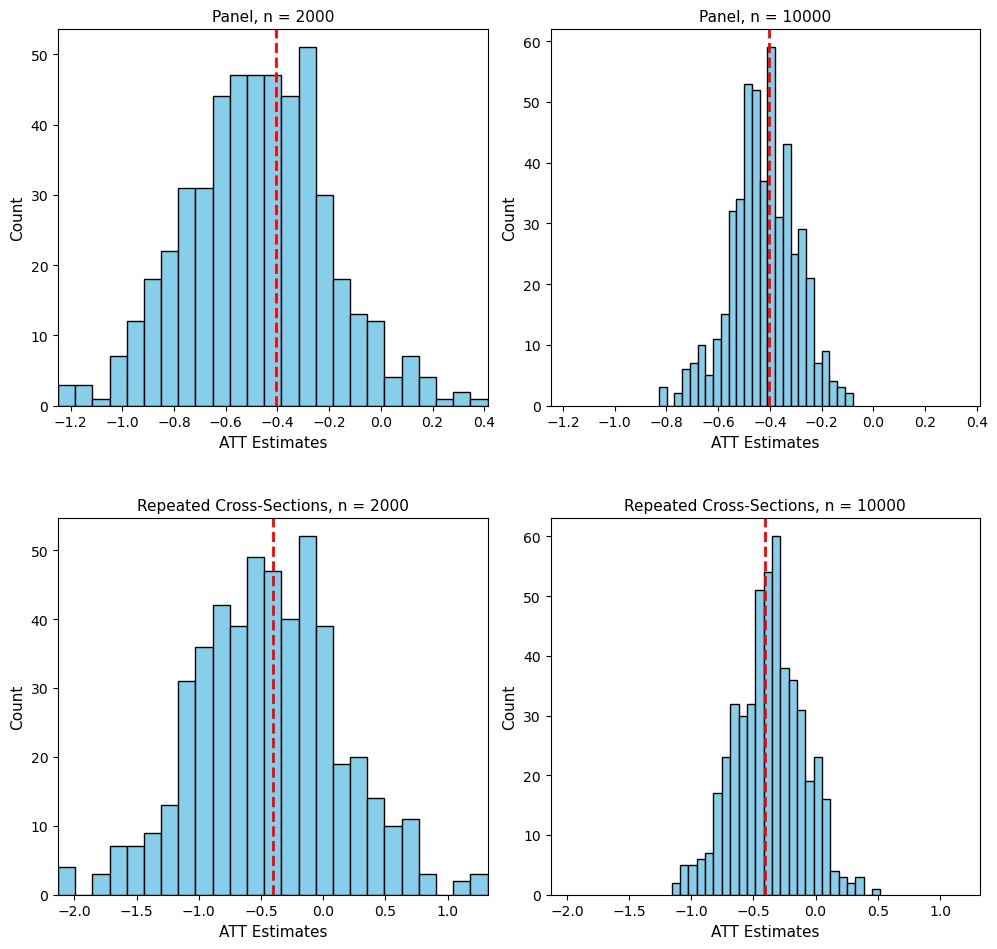

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# True ATT(d) at d = 0.9
true_val = -0.5 * 0.9 * 0.9

# Define common properties
props = dict(bins=25, color='skyblue', edgecolor='black')
line_props = dict(color='red', linestyle='dashed', linewidth=2)
title_props = dict(fontsize=11)
label_props = dict(fontsize=11)

# Determine the common x-axis range
x_min1 = min(results_df1.ATT.min(), results_df2.ATT.min())
x_max1 = max(results_df1.ATT.max(), results_df2.ATT.max())

x_min2 = min(results_df3.ATT.min(), results_df4.ATT.min())
x_max2 = max(results_df3.ATT.max(), results_df4.ATT.max())


# Plot for Panel Setting, n = 2000
axs[0, 0].hist(results_df1.ATT, **props)
axs[0, 0].axvline(true_val, **line_props)
axs[0, 0].set_title('Panel, n = 2000', **title_props)
axs[0, 0].set_xlabel('ATT Estimates', **label_props)
axs[0, 0].set_ylabel('Count', **label_props)
axs[0, 0].set_xlim([x_min1, x_max1])

# Plot for Panel Setting, n = 10000
axs[0, 1].hist(results_df2.ATT, **props)
axs[0, 1].axvline(true_val, **line_props)
axs[0, 1].set_title('Panel, n = 10000', **title_props)
axs[0, 1].set_xlabel('ATT Estimates', **label_props)
axs[0, 1].set_ylabel('Count', **label_props)
axs[0, 1].set_xlim([x_min1, x_max1])

# Plot for Repeated Cross-Sections Setting, n = 2000
axs[1, 0].hist(results_df3.ATT, **props)
axs[1, 0].axvline(true_val, **line_props)
axs[1, 0].set_title('Repeated Cross-Sections, n = 2000', **title_props)
axs[1, 0].set_xlabel('ATT Estimates', **label_props)
axs[1, 0].set_ylabel('Count', **label_props)
axs[1, 0].set_xlim([x_min2, x_max2])

# Plot for Repeated Cross-Sections Setting, n = 10000
axs[1, 1].hist(results_df4.ATT, **props)
axs[1, 1].axvline(true_val, **line_props)
axs[1, 1].set_title('Repeated Cross-Sections, n = 10000', **title_props)
axs[1, 1].set_xlabel('ATT Estimates', **label_props)
axs[1, 1].set_ylabel('Count', **label_props)
axs[1, 1].set_xlim([x_min2, x_max2])

# Add an overall title
#fig.suptitle('Monte Carlo Simulations, Histograms', fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect to make room for the suptitle
plt.subplots_adjust(hspace=0.3)  # Increase the vertical space between subplots

# Save the figure in high resolution
plt.savefig('simulation_histograms.png', dpi=300)

plt.show()

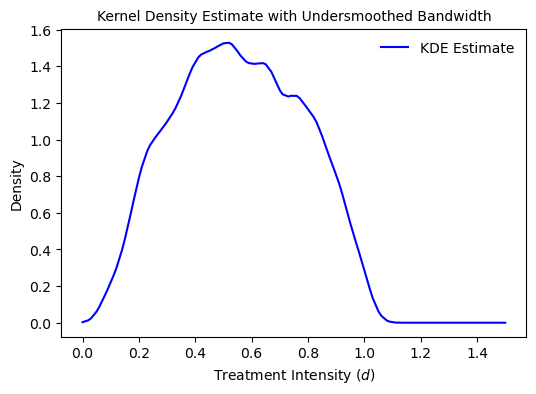

In [30]:
# OPTIONAL: PLOT KERNEL DENSITY OF THE CONTINUOUS TREATMENT

from sklearn.neighbors import KernelDensity

data_try = gen_panel(100, 10000, 1234)

# Extract positive D values
D_positive = data_try[data_try.D > 0].D.to_numpy()

# # Define a range of bandwidths for cross-validation search
# bandwidths = np.linspace(0.001, 0.5, 40)

# # Set cross-validation with controlled randomness
# cv = KFold(n_splits=5, shuffle=True, random_state=923)

# # Perform GridSearchCV with fixed seed
# grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=cv)
# grid.fit(D_positive[:, None])

# # Retrieve the optimal bandwidth and apply undersmoothing (3/4 factor)
h = np.round(1.06*np.std(data_try[data_try.D>0].D)*len(D_positive)**(-1/4), 4)


# Fit KDE with the selected bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(D_positive[:, None])

# Define evaluation points (dlist)
dlist = np.round(np.linspace(0, 1.5, 100), 2).tolist()
dlist_arr = np.array(dlist)[:, None]  # Convert to 2D array for KDE input

# Compute KDE estimates
log_dens = kde.score_samples(dlist_arr)
density_values = np.exp(log_dens)  # Convert log-density to actual density

# Plot KDE on dlist
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(dlist, density_values, color='blue', linewidth=1.5, label="KDE Estimate")
ax.set_xlabel(r'Treatment Intensity ($d$)', fontsize=10)
ax.set_ylabel(r'Density', fontsize=10)
ax.set_title(r'Kernel Density Estimate with Undersmoothed Bandwidth', fontsize=10)

# Improved legend
ax.legend(fontsize=10, loc='upper right', frameon=False)

# Remove top and right spines for cleaner look
#sns.despine()

# Show the plot
plt.show()